In [14]:
# 1. Load and Preprocess Burglary Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data and aggregate to ward-monthly counts
burglary = pd.read_csv('data/residential_burglary.csv')

# Combine 'Year' and 'Month' into a single datetime column
burglary ["Month"] = pd.to_datetime(burglary ["Year"].astype(str) + "-" + burglary ["Month"].astype(str), format="%Y-%m")

burglary_monthly = burglary.groupby(["Ward Code", "Month"]).size().reset_index(name="Count")

print("Raw data overview:")
print(f"Total wards: {burglary_monthly['Ward Code'].nunique()}")
print(f"Time range: {burglary_monthly['Month'].min()} to {burglary_monthly['Month'].max()}")

burglary_monthly


Raw data overview:
Total wards: 679
Time range: 2013-12-01 00:00:00 to 2025-02-01 00:00:00


,Ward Code,Month,Count
0,E05009317,2013-12-01,8
1,E05009317,2014-01-01,23
2,E05009317,2014-02-01,12
3,E05009317,2014-03-01,11
4,E05009317,2014-04-01,21
...,...,...,...
89633,E05014119,2024-10-01,1
89634,E05014119,2024-11-01,2
89635,E05014119,2024-12-01,4
89636,E05014119,2025-01-01,3


In [15]:
# 2. Load and process car ownership data

cars_df = pd.read_excel('data/housing/cars_or_vans_wards.xlsx', sheet_name='2021')
cars_df['NoCarPct'] = (cars_df['none'] / cars_df['All households'])
# cars = cars_df[['ward code', 'NoCarPct']].rename(columns={'ward code': 'ward_code'})

occupancy_df = pd.read_excel('data/housing/occupancy_rating_bedrooms_wards.xlsx', sheet_name='2021')
occupancy_df["ZeroRoomPct"] = (occupancy_df["0"] / occupancy_df["All Households"])
# occupancy = occupancy_df[["ward code", "ZeroRoomPct"]].rename(columns={'ward code': 'ward_code'})

cluster_df = pd.merge(cars_df, occupancy_df, on='ward code', how='inner')

print(f"Wards with both SARIMA and socio-economic data: {len(cluster_df)}")

cluster_df

Wards with both SARIMA and socio-economic data: 679


,ward code,ward name_x,local authority code_x,local authority name_x,All households,none,one,two,three or more,NoCarPct,ward name_y,local authority code_y,local authority name_y,All Households,Occupancy rating: +2 or more,+1,0,-1,-2 or less,ZeroRoomPct
0,E05014053,Abbey,E09000002,Barking and Dagenham,1453.0,950.0,412.0,79.0,12.0,0.653820,Abbey,E09000002,Barking and Dagenham,1455,102,225,754,327,47,0.518213
1,E05014054,Alibon,E09000002,Barking and Dagenham,3343.0,1086.0,1518.0,583.0,156.0,0.324858,Alibon,E09000002,Barking and Dagenham,3337,516,977,1288,454,102,0.385975
2,E05014055,Barking Riverside,E09000002,Barking and Dagenham,3391.0,1060.0,1777.0,465.0,89.0,0.312592,Barking Riverside,E09000002,Barking and Dagenham,3385,336,831,1591,515,112,0.470015
3,E05014056,Beam,E09000002,Barking and Dagenham,2699.0,900.0,1237.0,445.0,117.0,0.333457,Beam,E09000002,Barking and Dagenham,2703,520,738,992,371,82,0.367000
4,E05014057,Becontree,E09000002,Barking and Dagenham,3074.0,910.0,1409.0,567.0,188.0,0.296031,Becontree,E09000002,Barking and Dagenham,3071,452,822,1223,445,129,0.398242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,E05013805,Regent's Park,E09000033,Westminster,5655.0,3543.0,1686.0,336.0,90.0,0.626525,Regent's Park,E09000033,Westminster,5649,951,1680,2657,309,52,0.470349
675,E05013806,St James's,E09000033,Westminster,5159.0,3914.0,995.0,195.0,55.0,0.758674,St James's,E09000033,Westminster,5147,552,1422,2879,261,33,0.559355
676,E05013807,Vincent Square,E09000033,Westminster,5158.0,3544.0,1379.0,208.0,27.0,0.687088,Vincent Square,E09000033,Westminster,5170,482,1428,2767,401,92,0.535203
677,E05013808,West End,E09000033,Westminster,6072.0,4480.0,1249.0,277.0,66.0,0.737813,West End,E09000033,Westminster,6076,681,1607,3368,348,72,0.554312


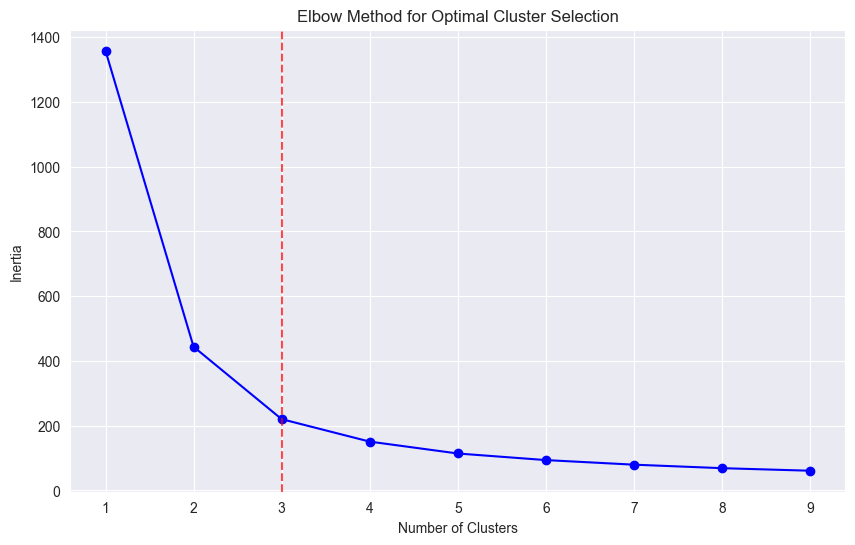

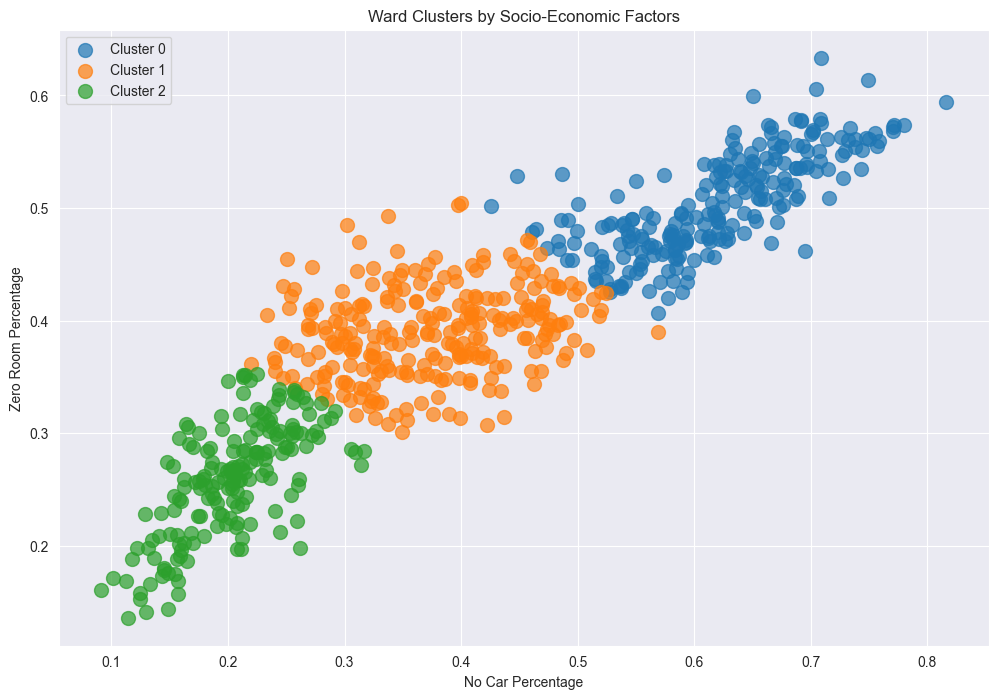

,Ward Code,Month,Count,NoCarPct,ZeroRoomPct,cluster
0,E05009317,2013-12-01,8,0.632145,0.484684,0
1,E05009317,2014-01-01,23,0.632145,0.484684,0
2,E05009317,2014-02-01,12,0.632145,0.484684,0
3,E05009317,2014-03-01,11,0.632145,0.484684,0
4,E05009317,2014-04-01,21,0.632145,0.484684,0
...,...,...,...,...,...,...
89633,E05014119,2024-10-01,1,0.424795,0.368940,1
89634,E05014119,2024-11-01,2,0.424795,0.368940,1
89635,E05014119,2024-12-01,4,0.424795,0.368940,1
89636,E05014119,2025-01-01,3,0.424795,0.368940,1


In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data
X = cluster_df[['NoCarPct', 'ZeroRoomPct']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Cluster Selection')
plt.axvline(x=3, color='r', linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()

# Fit final clusters (using k=3 from elbow)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
cluster_df['cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(12, 8))
for cluster_id in range(3):
    cluster_data = X[clusters == cluster_id]
    plt.scatter(cluster_data['NoCarPct'], cluster_data['ZeroRoomPct'],
                label=f'Cluster {cluster_id}', alpha=0.7, s=100)

# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], =300, c='black', marker='X', label='Centroids')
plt.xlabel('No Car Percentage')
plt.ylabel('Zero Room Percentage')
plt.title('Ward Clusters by Socio-Economic Factors')
plt.legend()
plt.grid(True)
plt.show()

# Merge clusters back to main data
cluster_df = (cluster_df[['ward code', 'NoCarPct', 'ZeroRoomPct', "cluster"]]
              .rename(columns={'ward code': 'Ward Code'})
              .copy())
merged_data = pd.merge(burglary_monthly, cluster_df, on='Ward Code', how='left')
merged_data

In [21]:
import warnings

warnings.filterwarnings("ignore")

# Define optimal orders for each cluster
# Rationale for cluster-specific orders:
# - Cluster 2 (High Deprivation): Higher q (3) for responsiveness to large absolute changes
# - Cluster 0 (Low Deprivation): Higher p (2) for capturing persistent patterns
# - All clusters: Reduced seasonal complexity (P≤1) based on your findings
CLUSTER_ORDERS = {
    0: {'normal': (2,1,2), 'seasonal': (1,1,1,12)},  # Low deprivation
    1: {'normal': (3,1,1), 'seasonal': (0,1,1,12)},   # Medium deprivation
    2: {'normal': (1,1,3), 'seasonal': (0,1,2,12)}    # High deprivation
}
TEST_MONTHS = 26

def analyze_ward_cluster(args):
    ward_code, ward_df = args
    try:
        # Get cluster-specific orders
        cluster_id = cluster_df[cluster_df['Ward Code'] == ward_code]['cluster'].values[0]
        orders = CLUSTER_ORDERS[cluster_id]

        # Prepare dataframe
        ward_df = ward_df[['Month', 'Count']].set_index('Month').asfreq('MS')

        if ward_df.isnull().values.any():
            print(f"{ward_code} has NaN values")
            if ward_df.isnull().sum().sum() > 10:
                print(f"{ward_code} has more than 10 NaN values, aborted")
                return None
            ward_df.ffill(inplace=True)

        # Filter wards with sufficient history
        if len(ward_df) < TEST_MONTHS * 2:
            print(f"{ward_code} has insufficient data")
            return None

        # Split data
        train = ward_df.iloc[:-TEST_MONTHS]
        test = ward_df.iloc[-TEST_MONTHS:]

        # Fit SARIMAX with cluster-specific orders
        model = SARIMAX(train,
                       order=orders['normal'],
                       seasonal_order=orders['seasonal'])  # Using cluster-defined seasonal order
        results = model.fit(disp=False)

        # Generate predictions
        preds = results.get_forecast(steps=TEST_MONTHS).predicted_mean

        # Calculate residuals
        residuals = test['Count'].values - preds.values

        print(f"{ward_code} completed")

        return {
            'ward_code': ward_code,
            'cluster': cluster_id,
            'residuals': residuals,
            'predicted': preds.values,
            'actual': test['Count'].values,
            'orders_normal': orders['normal'],
            'orders_seasonal': orders['seasonal']
        }
    except Exception as e:
        print(f"Error processing {ward_code}: {str(e)}")
        return None

# Process all wards
results = []
# i = 0
for ward_code, group in burglary_monthly.groupby('Ward Code'):
    analysis = analyze_ward_cluster((ward_code, group))
    if analysis:
        results.append(analysis)
    #     i += 1
    # if i > 100:
    #     break   # just to test a few wards, not all

# Remove Empty results
results = [res for res in results if res is not None]

print(f"\nSuccessfully processed {len(results)} wards with sufficient data")

warnings.filterwarnings("default")


E05009317 completed
E05009318 completed
E05009319 completed
E05009320 completed
E05009321 has NaN values
E05009321 completed
E05009322 completed
E05009323 completed
E05009324 has NaN values
E05009324 completed
E05009325 completed
E05009326 has NaN values
E05009326 has more than 10 NaN values, aborted
E05009327 completed
E05009328 has NaN values
E05009328 has more than 10 NaN values, aborted
E05009329 completed
E05009330 completed
E05009331 completed
E05009332 completed
E05009333 completed
E05009334 completed
E05009335 completed
E05009336 completed
E05009367 has NaN values
E05009367 completed
E05009368 has NaN values
E05009368 completed
E05009369 completed
E05009370 completed
E05009371 completed
E05009372 completed
E05009373 completed
E05009374 completed
E05009375 completed
E05009376 completed
E05009377 completed
E05009378 completed
E05009379 completed
E05009380 completed
E05009381 completed
E05009382 completed
E05009383 completed
E05009384 has NaN values
E05009384 completed
E05009385 c


Cluster Performance Metrics:
   cluster  n_wards   avg_mae  avg_rmse normal_order seasonal_order
0        0      225  3.311664  4.133091    (2, 1, 2)  (1, 1, 1, 12)
1        1      255  2.696412  3.378757    (3, 1, 1)  (0, 1, 1, 12)
2        2      151  2.417655  3.102719    (1, 1, 3)  (0, 1, 2, 12)


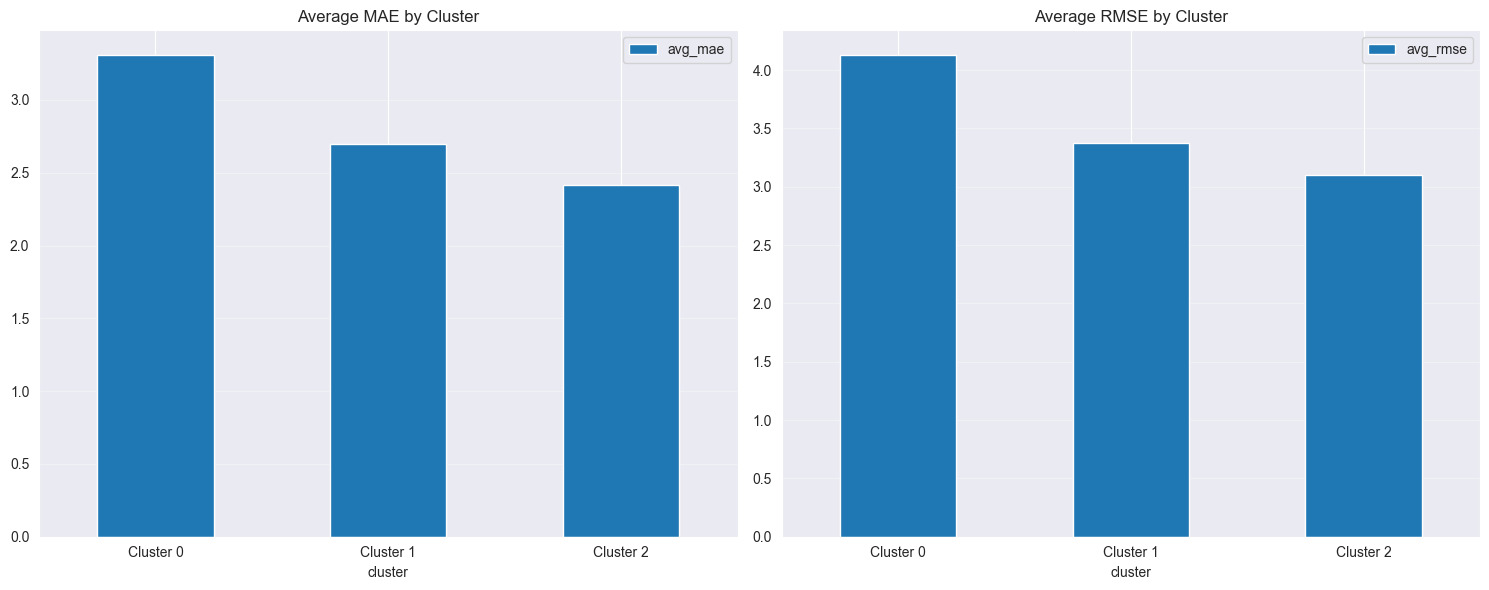

In [22]:
# Calculate metrics per cluster

results_df = pd.DataFrame(results)

cluster_results = []
for cluster_id in range(3):
    cluster_data = results_df[results_df['cluster'] == cluster_id]
    cluster_mae = cluster_data['residuals'].apply(lambda x: np.mean(np.abs(x))).mean()
    cluster_rmse = cluster_data['residuals'].apply(lambda x: np.sqrt(np.mean(np.square(x)))).mean()

    cluster_results.append({
        'cluster': cluster_id,
        'n_wards': len(cluster_data),
        'avg_mae': cluster_mae,
        'avg_rmse': cluster_rmse,
        'normal_order': CLUSTER_ORDERS[cluster_id]['normal'],
        'seasonal_order': CLUSTER_ORDERS[cluster_id]['seasonal']
    })

# Display results
cluster_metrics = pd.DataFrame(cluster_results)
print("\nCluster Performance Metrics:")
print(cluster_metrics[['cluster', 'n_wards', 'avg_mae', 'avg_rmse', 'normal_order', 'seasonal_order']])

# Visualize comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
cluster_metrics.plot(x='cluster', y='avg_mae', kind='bar', ax=ax[0], title='Average MAE by Cluster')
cluster_metrics.plot(x='cluster', y='avg_rmse', kind='bar', ax=ax[1], title='Average RMSE by Cluster')
for i in range(2):
    ax[i].set_xticklabels([f'Cluster {i}' for i in cluster_metrics['cluster']], rotation=0)
    ax[i].grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()